In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gpytorch.priors import Prior, NormalPrior, GammaPrior

from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import ExpectedImprovementGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

sys.path.append("../")
from utils import visualize_generator_model
sys.path.append("../calibration/calibration_modules/")
from decoupled_linear import OutputOffset, OutputScale, DecoupledLinearOutput

In [2]:
# fix random seeds
rng_seed = 0  # negative posterior with: 0, 8, 9
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)

## Load Xopt Run

In [3]:
def get_model_predictions(input_dict, generator = None):
    output_dict = {}
    for output_name in generator.vocs.output_names:
        if generator is not None and generator.model is not None:
            gp = generator.model.models[generator.vocs.output_names.index(output_name)]
            x = torch.tensor([input_dict[k] for k in generator.vocs.variable_names], dtype=torch.double).unsqueeze(0)
            with torch.no_grad():
                _x = gp.input_transform.transform(x)
                _x = gp.mean_module(_x)
                prior_mean = gp.outcome_transform.untransform(_x)[0].item()
                posterior = gp.posterior(x)
                posterior_mean = posterior.mean.item()
                posterior_sd = torch.sqrt(posterior.mvn.variance).item()
        else:
            prior_mean, posterior_mean, posterior_sd = np.nan, np.nan, np.nan
    
        output_dict[output_name + "_prior_mean"] = prior_mean
        output_dict[output_name + "_posterior_mean"] = posterior_mean
        output_dict[output_name + "_posterior_sd"] = posterior_sd
    return output_dict

In [4]:
def eval_beamsize(input_dict):
    pass

In [5]:
data_dir = "../../data/20231009_LCLS_Injector/"
filename = "nn_optimization_9d_4_fixed_offset.yml"

with open(data_dir + filename) as f:
    X = Xopt.from_yaml(f)
X.data.index = X.data.index.values.astype(int)
X.data = X.data.sort_index()
# X.data = X.data.dropna(subset=["total_size"])

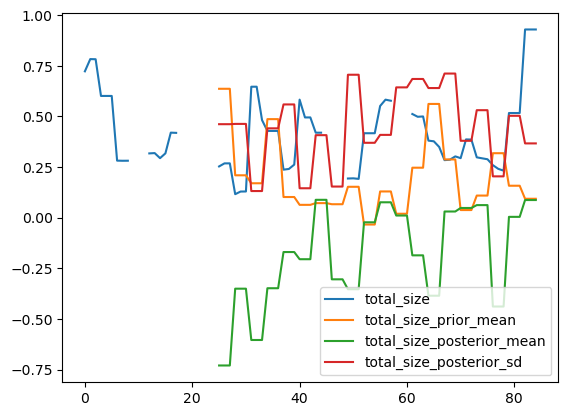

In [6]:
X.data[["total_size" + k for k in ["", "_prior_mean", "_posterior_mean", "_posterior_sd"]]].plot();

## Load NN Prior Model

In [7]:
objective_scale = 1e-3

In [8]:
model_path = "../lcls_cu_injector_nn_model/"

# load sim_to_nn transformers
input_sim_to_nn = torch.load(model_path + "model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_path + "model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load(model_path + "model/input_pv_to_sim.pt")
output_pv_to_sim = torch.load(model_path + "model/output_pv_to_sim.pt")

# load in- and output variable specification
input_variables, output_variables = variables_from_yaml(open(model_path + "model/pv_variables.yml"))

# replace keys in input variables
input_variables = {name.replace("BACT", "BCTRL"): ele for name, ele in input_variables.items()}

# create LUME-model
lume_model = PyTorchModel(
    model_file=model_path + "model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],
    output_transformers=[output_sim_to_nn, output_pv_to_sim],
)

# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=X.vocs.variable_names,
    output_order=lume_model.outputs[0:2],
)

# define objective model
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        sigma_xy = torch.sqrt(sigma_x ** 2 + sigma_y ** 2)
        roundness = torch.abs(sigma_x - sigma_y)
        return objective_scale * (sigma_xy + roundness)

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("OTRS:IN20:571:XRMS")
        idx_sigma_y = self.model.output_order.index("OTRS:IN20:571:YRMS")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)

objective_model = ObjectiveModel(lume_module)

In [9]:
# define custom mean
objective_model.requires_grad_(False);

# custom_mean = objective_model
prior_mean = OutputOffset(
    model=objective_model,
    y_offset_initial=torch.tensor([-0.11378330615144132]),
    y_offset_prior=NormalPrior(loc=torch.tensor([-0.11378330615144132]), scale=torch.ones(1)),
)
prior_mean.requires_grad_(False);

## Negative Posterior Values

In [10]:
# X.data["total_size_posterior_mean"].values[:25]

In [11]:
idx = 25
input_dict = X.data.iloc[idx][X.vocs.variable_names].to_dict()
input_dict

{'QUAD:IN20:121:BCTRL': -0.0108871992,
 'QUAD:IN20:122:BCTRL': -0.0121403835,
 'QUAD:IN20:361:BCTRL': -3.568624322,
 'QUAD:IN20:371:BCTRL': 2.7529233755,
 'QUAD:IN20:425:BCTRL': -0.8622391664,
 'QUAD:IN20:441:BCTRL': -0.4597770582,
 'QUAD:IN20:511:BCTRL': 3.9412584252,
 'QUAD:IN20:525:BCTRL': -3.0437697585,
 'SOLN:IN20:121:BCTRL': 0.4712248377}

In [12]:
input_tensor = torch.tensor([v for k, v in input_dict.items()]).unsqueeze(0)
output_tensor = prior_mean(input_tensor)
output_tensor.item()

0.636853814125061

In [13]:
# create Xopt object from scratch
model_constructor = StandardModelConstructor(
    use_low_noise_prior=False,
    mean_modules={X.vocs.objective_names[0]: prior_mean},
)
generator = ExpectedImprovementGenerator(
    vocs=X.vocs,
    model_constructor=model_constructor,
)
generator.numerical_optimizer.max_iter = 200
evaluator = Evaluator(function=eval_beamsize, function_kwargs={"generator": generator})
X_new = Xopt(generator=generator, evaluator=evaluator, vocs=X.vocs)
X_new.evaluator = Evaluator(function=eval_beamsize, function_kwargs={"generator": X_new.generator})

In [14]:
# add data and train model
X_new.add_data(X.data.iloc[:idx])
_ = X_new.generator.train_model(X_new.data)

In [15]:
print(X.data.iloc[idx][X.vocs.objective_names[0] + "_posterior_mean"])
print(get_model_predictions(input_dict, X_new.generator)[X.vocs.objective_names[0] + "_posterior_mean"])

-0.7300620075
-0.4594289985485475


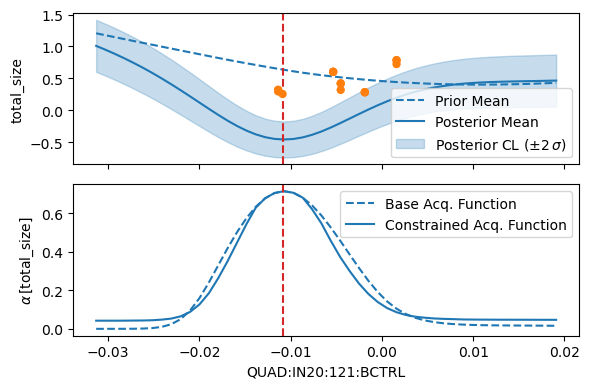

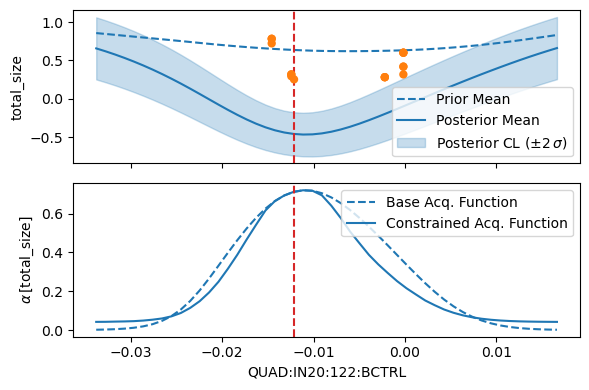

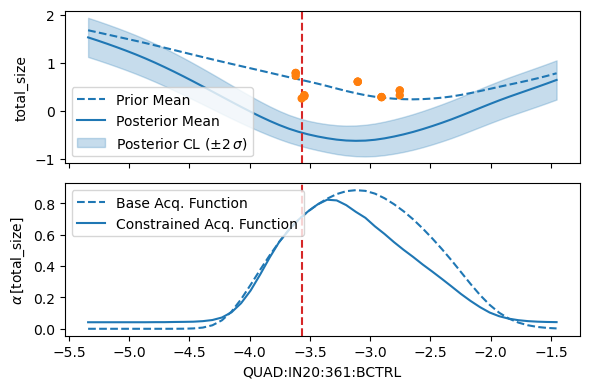

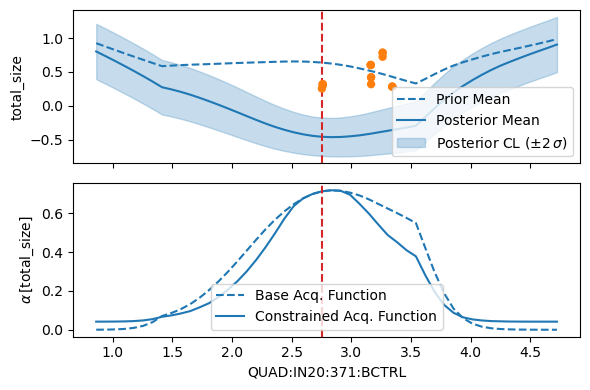

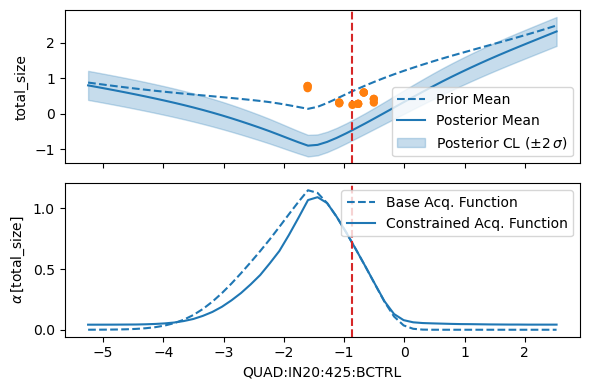

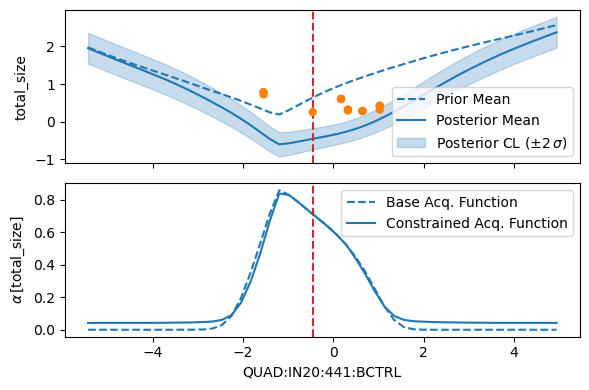

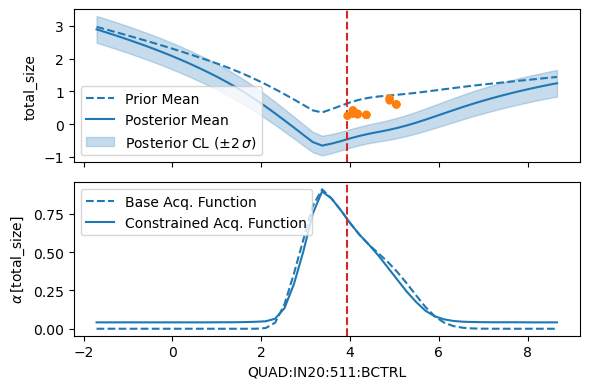

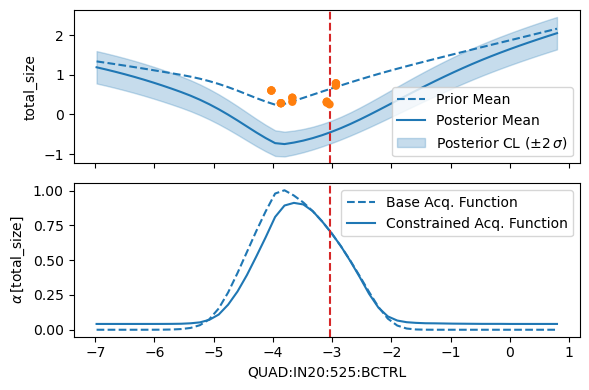

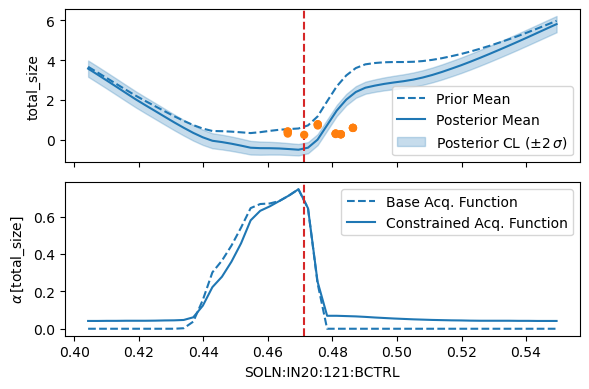

In [16]:
for name in X_new.vocs.variable_names:
    fig, ax = visualize_generator_model(
        generator=X_new.generator,
        output_names=[X_new.vocs.output_names[0]],
        variable_names=[name],
        reference_point=input_dict,
        show_prior_mean=True,
        scale_variable_range=1.0,
    )
    for ax_i in ax.flatten():
        ax_i.axvline(x=input_dict[name], linestyle="--", c="C3")
    fig.tight_layout()

In [17]:
var_names, ls = [], []
gp = X_new.generator.model.models[X_new.generator.vocs.output_names.index(X.vocs.objective_names[0])]
for i, name in enumerate(X_new.vocs.variable_names):
    var_names.append(name)
    ls.append(gp.covar_module.base_kernel.lengthscale[0, i].item())
lengthscales = pd.DataFrame({"Lengthscale": ls}, index=var_names)
lengthscales

,Lengthscale
QUAD:IN20:121:BCTRL,0.605525
QUAD:IN20:122:BCTRL,0.715846
QUAD:IN20:361:BCTRL,0.690064
QUAD:IN20:371:BCTRL,0.657038
QUAD:IN20:425:BCTRL,0.671712
QUAD:IN20:441:BCTRL,0.630962
QUAD:IN20:511:BCTRL,0.676650
QUAD:IN20:525:BCTRL,0.682395
SOLN:IN20:121:BCTRL,0.672312


In [18]:
gp.likelihood.noise_covar.noise.item()

2.655563316666913

In [19]:
from gpytorch import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_mll

In [20]:
model = X_new.generator.model.models[0]
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_mll = fit_gpytorch_mll(mll)

In [21]:
fit_mll.training

False

In [22]:
print(get_model_predictions(input_dict, X_new.generator)[X.vocs.objective_names[0] + "_posterior_mean"])

0.1080411404739236


In [23]:
var_names, ls = [], []
gp = X_new.generator.model.models[X_new.generator.vocs.output_names.index(X.vocs.objective_names[0])]
for i, name in enumerate(X_new.vocs.variable_names):
    var_names.append(name)
    ls.append(gp.covar_module.base_kernel.lengthscale[0, i].item())
lengthscales = pd.DataFrame({"Lengthscale": ls}, index=var_names)
lengthscales

,Lengthscale
QUAD:IN20:121:BCTRL,0.413666
QUAD:IN20:122:BCTRL,0.385080
QUAD:IN20:361:BCTRL,0.339339
QUAD:IN20:371:BCTRL,0.347477
QUAD:IN20:425:BCTRL,0.319111
QUAD:IN20:441:BCTRL,0.196467
QUAD:IN20:511:BCTRL,0.328495
QUAD:IN20:525:BCTRL,0.344224
SOLN:IN20:121:BCTRL,0.301208
